# Transfer learning 

Каждый раз, обучая нейронку, мы сначала рандомно инициализируем веса, а после в ходе бэкпропа обучаем модель. Если мы сразу же угадываем хорошие веса, модель сходится быстрее. Иногда можно брать в качестве инициализации веса, полученные другими исследователями и на их основе дообучать модель под свой выход. Это здорово упрощает задачу обучения и экономит недели работы.

Transfer learning это когда ты берёшь чужую модель и адаптируешь её под свою задачу. В этой тетрадке мы  посмотрим на то, как в tensorflow можно этим заняться.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


# 1. Реквизируем MobileNet 

В прошлый раз мы обсуждали то, как люди Imagenet рвали. В ходе этого обсуждения мы посмотрели на многие модные архитектуры. В самом конце мы сказали, что добившись высокого качества, Google решил, что надо бы сделать свои сетки более компактными, чтобы они влазили в мобилу. Одним из результатов этой работы стало создание [архитектуры MobileNetV2.](https://arxiv.org/abs/1801.04381) Она была собрана и обучена на ImageNet в апреле 2018 года. Если говорить грубо, MobileNet это почти как Inception, но меньше. 

In [1]:
import requests
import tensorflow.keras.applications as zoo  # как зоопарк подгружаем, азазазазаз

Давайте возьмём предобученную модель из Keras и просто попробуем её для чего-нибудь поиспользовать. 

In [2]:
model = zoo.MobileNetV2(include_top=True, weights='imagenet')

14540800/14536120 [==============================] - 3s 0us/step


Опция `weights` отвечает за то, на каком датасете предобучена модель. Опция `include_top` отвечает за то, скачиваем мы модель полностью или только `feature extractor`, то есть только первые слои. Мы скачали всё. 

In [3]:
# Узнаем размерность входа и выхода
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

Теперь попробуем что-нибудь спрогнозировать. В модуле `keras.utis` есть функция `get_file`, которая умеет скачивать и разархивировать разные файлы. Будем использовать её для скачки картинок по ссылкам. 

In [4]:
from tensorflow.keras.utils import get_file

122880/120478 [==============================] - 0s 0us/step
/home/care1e55/.keras/datasets/cat.jpg


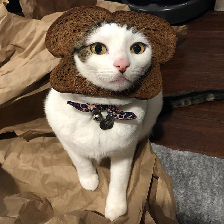

In [5]:
import PIL.Image
import numpy as np

href = 'https://sadanduseless.b-cdn.net/wp-content/uploads/2019/06/cat-breading4.jpg'
image = get_file('cat.jpg', href)

print(image) # куда скачался то?! 

image = PIL.Image.open(image).resize(input_shape)
image 

In [6]:
# немного предобработки
image = np.array(image)/255.0
image.shape

(224, 224, 3)

In [7]:
# вот так можно добавить фиктивную размерность
image[np.newaxis, :,:,:].shape

(1, 224, 224, 3)

In [30]:
# строим прогноз 
result = model.predict(image[np.newaxis, :,:,:])
result.shape

(1, 1000)

Готово! У нас есть $1000$ вариантов прогноза. Если быть более конкретным, нас в случае данного изображения устраивает класс номер

In [31]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

281

In [32]:
result[0].argsort()[-5:][::-1] # топ-5 классов

array([281, 284, 338, 285, 452])

Осталось только выяснить что это за класс. Для этого нам нужны метки Imagenet. Скачаем их. Они тоже уже есть в пакете. Удобно. 

In [33]:
from tensorflow.python.keras.applications.vgg16 import decode_predictions
decode_predictions(result)[0]

[('n02123045', 'tabby', 0.05511342),
 ('n02123597', 'Siamese_cat', 0.045025393),
 ('n02364673', 'guinea_pig', 0.03821017),
 ('n02124075', 'Egyptian_cat', 0.030809322),
 ('n02869837', 'bonnet', 0.029485954)]

Напишем функцию для строительства прогнозов и попробуем ещё. 

In [34]:
import matplotlib.pyplot as plt

def save_image(href, save_name):
    img = get_file(save_name, href)
    return img
    
def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # тут чуть подрбнее про ресайзы: https://habr.com/ru/post/247219/
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Кнвертируем картинку в numpy и делаем лишнюю размерность
    img_array = np.array(img_resized)[np.newaxis, ...]

    # VGG-16 строит нам прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

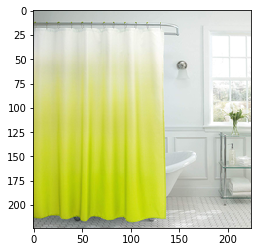

66.11% : shower_curtain
 7.38% : window_shade
 4.33% : pillow
 2.39% : slot
 1.87% : window_screen


In [35]:
href = 'https://images-na.ssl-images-amazon.com/images/I/91NKh-FPcBL._SL1500_.jpg'
path = save_image(href, 'shower_curtain.jpg')
predict(path)

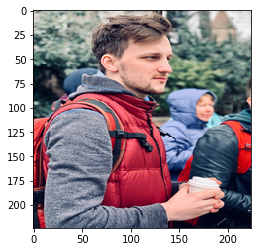

53.39% : pillow
14.11% : shower_curtain
 7.31% : handkerchief
 7.01% : envelope
 4.82% : bib


In [36]:
href = 'https://sun9-34.userapi.com/c850216/v850216669/110118/s1XSv_XLgtY.jpg'
path = save_image(href, 'the_most_awesome_boy.jpg')
predict(path)

__Последняя картинка как-то исказилась.__  Когда мы делаем `.resize`, мы используем опцию `PIL.Image.LANCZOS` она делает кое-какие приятные ништяки, связанные с защитой изображения от искажений. Вообще борьба с искажениями и разными размерностями у картинок - один из этапов предобработки. 

Как добиться того, чтобы картинка не искажалась? Использовать какие-то похожие фильры, либо обрезать картинки. Давайте попробуем написать в numpy функцию, которая будет заниматься обрезанием картинок вот по такой схеме: 

<img src="https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/week3/images/center_crop.jpg" style="width:50%">

Попробуйте самостоятельно сделать её.

In [43]:
# Функция для обрезания картинок 
def image_center_crop(img):
    w = img.shape[0]
    h = img.shape[1]
    if w > h :
        cropped_img = img[(w-h)//2:w-(w-h)//2,:,:]
    elif w < h:
        cropped_img = img[:,(h-w)//2:h-(h-w)//2,:]
    else:
        cropped_img = img
    return cropped_img

Вставим эту функцию в построение прогнозов. 

In [44]:
def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # переделали в массив, обрезали 
    img = image_center_crop(np.array(img)) 
    
    # вернули назад в картинку, сделали resize 
    img_resized = PIL.Image.fromarray(img).resize(input_shape)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Кнвертируем картинку в numpy и делаем лишнюю размерность
    img_array = np.array(img_resized)[np.newaxis, ...]

    # VGG-16 строит нам прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

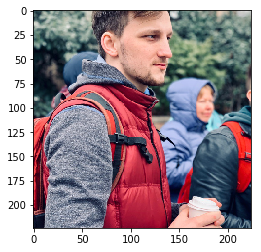

54.96% : pillow
10.28% : shower_curtain
 6.32% : envelope
 4.30% : handkerchief
 4.21% : bib


In [45]:
href = 'https://sun9-34.userapi.com/c850216/v850216669/110118/s1XSv_XLgtY.jpg'
path = save_image(href, 'the_most_awesome_boy.jpg')
predict(path)

В `ImageNet` нет людей. Поэтому можно попробовать выяснить на кого именно ты сильнее всего похож. Чаще всего это будет либо подушка либо занавеска. Если выпадает что-то другое, тебе крупно повезло. 

In [40]:
########################
# Твой код с картинкой
########################

# 2. Transfer learning 

Побаловались с прогнозами, теперь давайте займёмся более серьёзными проблемами. Например, попробуем решить проблему тысячелетия вслед за [лучшими китайскими учёными.](https://www.youtube.com/watch?v=vIci3C4JkL0)


![](https://www.semantics3.com/blog/content/images/downloaded_images/hot-dog-and-a-not-hot-dog-the-distinction-matters-code-included-8550067fb16/1-VrpXE1hE4rO1roK0laOd7g.png)


По мотивам этой великой проблемы даже сделали [соревнование на kaggle.](https://www.kaggle.com/c/hotdogornot)  Но да лдано. Давайте лучше скачаем [папку с картинками](https://yadi.sk/d/AJra6kvvWV77nA) и приступим к работе. 

## 2.1 Данные 

Для начала попробуем применить нашу модель и посмотреть что будет происходить.

In [41]:
# Нет, наш курс не мелкий! Просто я не придумал более хорошего места для данных на своём диске
data_root = "/Users/fulyankin/Yandex.Disk.localized/Выступления и мелкие курсы/NN_ranepa/hotdogornot/"

Забивать оперативную память лишними гигабайтами картинок не очень хочется, поэтому мы будем считывать картинки с жёсткого диска. Напишем для этого генератор, который будет считывать картинки по одной. 

In [42]:
# идём в керасовский модуль и берём из него функцию для генератора
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# внутри генератора есть очень широкие возможности для аугментации, на них вы посмотрите в дз
image_generator = ImageDataGenerator(rescale=1/255)

# натравливаем гинератор на конкретную директорию c данными
image_data = image_generator.flow_from_directory(data_root, 
                                                 batch_size=32,           # размер батча
                                                 target_size=input_shape  # размер входных данных для сетки
                                                )

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fulyankin/Yandex.Disk.localized/Выступления и мелкие курсы/NN_ranepa/hotdogornot/'

Посмотрим на характеристики батчей, которые лежат внутри генератора. 

In [20]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

NameError: name 'image_data' is not defined

Можно посмотреть на число шагов, которое собрался делать генератор. 

In [21]:
image_data.n

NameError: name 'image_data' is not defined

А ещё на названия классов. 

In [22]:
image_data.class_indices.keys()

NameError: name 'image_data' is not defined

Давайте прогоним текущий батч через нейронку и посмотрим на прогнозы. 

In [23]:
# построим прогнозы по батчу из картинок
result_batch = model.predict(image_batch)

NameError: name 'image_batch' is not defined

In [24]:
# што там у нас спрогнозировалось? 
labels_batch = [item[0] for item in decode_predictions(result_batch)]

NameError: name 'result_batch' is not defined

Посмотрим на  картинки и построенные по ним прогнозы. 

In [ ]:
cols = 5
rows = 3
fig = plt.figure(figsize=(4 * cols - 1, 5 * rows - 1))

k = 0 
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(image_batch[k])
        ax.set_title("{0:>6.2%} : {1}".format(labels_batch[k][2], labels_batch[k][1]), size=14)
        k += 1
plt.show()

Модель отрабатывает на уровне выше всех похвал (но это неточно).

## 2.2 Дообучаем сетку

Предобученная сетка не приспособлена для работы с нашими классами. Давайте заставим её их выучить. Для этого нам придётся срезать с сетки её последние слои. Посмотрим на `summary` модели. 

In [ ]:
model.summary()

Довольно большое полотно. Давайте срежем в нашей сетки всё до слоя с логитом. Обратимся к слою, который мы хотели бы получить по имени. 

In [ ]:
transfer_layer = model.get_layer('global_average_pooling2d')

Выход этого слоя мы будем использовать для создания своей нейронки. Этот слой - обычный тензор. 

In [25]:
transfer_layer.output

NameError: name 'transfer_layer' is not defined

В Keras довольно просто приказать нашему графу выбрасывать на выход из модели нужный нам кусок. 

In [26]:
from tensorflow.python.keras.models import Model

# Просто-напросто оформим нужный нам кусок нейросетки как модельку 
# Можно было бы оформить её как отдельный слой (сделаем это ниже)
feature_extractor = Model(inputs=model.input,
                   outputs=transfer_layer.output)

NameError: name 'transfer_layer' is not defined

Теперь построим на основе экстрактора новую модель. 

In [27]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

# Старт новой модели
new_model = Sequential()

# Первый слой в ней это экстрактор фичей 
new_model.add(feature_extractor)

# можно добавить много промежуточных слоёв, если хочется

# финальный софтмакс слой 
new_model.add(Dense(7, activation='softmax'))

NameError: name 'feature_extractor' is not defined

Посмотрим на то, какие слои собрались обучаться. 

In [28]:
def print_layer_trainable():
    for layer in feature_extractor.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
        
print_layer_trainable()    

NameError: name 'feature_extractor' is not defined

Запретим Keras обучать веса внутри нашего экстрактора фичей. Это непозволительная роскошь. Тем более он уже предобучен на `Imagenet.` Запретим ему заниматься этим.  

In [29]:
feature_extractor.trainable = False

for layer in feature_extractor.layers:
    layer.trainable = False
    
print_layer_trainable( )

NameError: name 'feature_extractor' is not defined

Проверяем запускается ли модель, которую мы собрали и что она выдаёт на выходе.

In [ ]:
result = new_model.predict(image_batch)
result.shape

Теперь наконец мы можем скомпилировать модель.  Оптимизировать всё это чудо будет нами горячо любимый Adam.  Каждую эпоху (полный проход по данным) в ходе алгоритма обратного распространения ошибки, мы будем обучать только последние слои. Одна эпохо в данном случае - проход по всем картинкам из наших папочек. Будем учить сетку $5$ эпох. 

In [40]:
new_model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss='categorical_crossentropy',
      metrics=['acc']
)

# число шагов до конца первой эпохи
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

# учим сетку одну эпоху
new_model.fit(image_data, epochs=5, 
            steps_per_epoch = steps_per_epoch)

Train for 144.0 steps
Epoch 1/5
144/144 [==============================] - 269s 2s/step - loss: 0.9800 - acc: 0.6633
Epoch 2/5
144/144 [==============================] - 249s 2s/step - loss: 0.5807 - acc: 0.7849
Epoch 3/5
  1/144 [..............................] - ETA: 2:26:47

KeyboardInterrupt: 

Давайте посмотрим на текущие прогнозы сетки. 

In [ ]:
# построим прогнозы по батчу из картинок
result_batch = new_model.predict(image_batch)

In [ ]:
result_batch[:2]

In [ ]:
classes = list(image_data.class_indices.keys())
classes

In [ ]:
np.argmax(result_batch, axis=1)

In [ ]:
labels_batch = [classes[i] for i in np.argmax(result_batch, axis=1)]
labels_batch[:10]

In [ ]:
labels_batch = list(zip(np.max(result_batch, axis=1), labels_batch))
labels_batch[:10]

In [ ]:
cols = 5
rows = 3
fig = plt.figure(figsize=(4 * cols - 1, 5 * rows - 1))

k = 0 
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(image_batch[k])
        ax.set_title("{0:>6.2%} : {1}".format(labels_batch[k][0], labels_batch[k][1]), size=14)
        k += 1
plt.show()

Явно стало лучше :) 

# 3. Tensor hub 

В $2017$ году Google сделал специальную платформу __TensorFlow Hub.__  Она используется для того, чтобы делиться друг с другом моделями. В таком формате свои результаты сохраняют различные исслодовательские группы. В том числе Россияская группа IPavlov. В следующие разы мы будем воровать у них модели через эту библиотечку.  

Сейчас давайте посмотрим как это делается. Для начала нужно установить `tensorflow_hub` на свой компьютер через __pip.__

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)
print(hub.__version__)

## 3.1 Собираем модель

По [ссылке](https://tfhub.dev) можно найти зоопарк моделей от Google для открытого использования через библиотеку. Мы выберем среди всего этого огромного числа моделек архитектуру [MobileNetV2,](https://arxiv.org/abs/1801.04381) обученную Google в апреле 2018 года на ImageNet. Эта сетка - развитие Inception. Подробнее про неё можно почитать либо в [оригинальной статье,](https://arxiv.org/abs/1801.04381) либо [на Хабре.](https://habr.com/ru/post/352804/)

Сетка подгружается библиотекое tensorflow_hub просто по ссылке.

In [ ]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 
hub_module =  hub.load(url)

 Дальше мы можем завернуть её в удобную функцию и начать применять. 

In [ ]:
IMAGE_SHAPE = [224, 224]

classifier = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape=IMAGE_SHAPE+[3])
])

In [ ]:
# input shape такой, потому что три канала
IMAGE_SHAPE + [3]

In [ ]:
classifier.summary()

Запустим сетку на изображении. 

In [ ]:
href = 'https://sadanduseless.b-cdn.net/wp-content/uploads/2019/06/cat-breading4.jpg'
image = get_file('cat.jpg', href)

print(image) # куда скачался то?! 

image = PIL.Image.open(image).resize(input_shape)
image = np.array(image)/255

classifier.predict(image[np.newaxis, ...])

При желании можно узнать что за класс получился на выходе по аналогии с тем, как мы сделали это в самом начале тетрадки.

## 3.2 Дообучаем сетку

Доучивать её мы будем на тех же самых данных по хотдогам. 

In [ ]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Нам для дообучения понадобится только feature extractor, его мы и скачаем.

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

Посмотрим что будет идти из этого экстрактора на выход. 

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

Запретим tensorflow тренировать веса экстрактора.

In [ ]:
feature_extractor_layer.trainable = False

Cобираем модель, на последний слой вытаскиваем softmax на 7 классов


In [ ]:
image_data.num_classes

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  Dense(image_data.num_classes, activation='softmax')
])

model.summary()

In [ ]:
# проверяем запускается ли модель, которую мы собрали и что она выдаёт на выходе
result = model.predict(image_batch)
result.shape

Собираем модель и запускаем обучение.

In [ ]:
model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss='categorical_crossentropy',
      metrics=['acc']
)

# число шагов до конца первой эпохи
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

# учим сетку одну эпоху
model.fit(image_data, epochs=3, 
            steps_per_epoch = steps_per_epoch)

По аналогии с кодом выше можно посмотреть что наша модель будет прогнозировать. Не будем копипастить. Лучше сделаем другую вещь. Мы довольно долго учили модельку. Давайте её сохраним на компьютер. Модели на комп можно сохранять в разных видах и форматах. Про это ещё поговорим.

In [ ]:
export_path = tf.keras.models.save_model(model, "./saved_models")
export_path

In [ ]:
!ls saved_models

Обратите внимание, что мы здесь не дробили выборку на трэйн и тест, а просто дообучали сетку сразу и на всём. Делали мы это для того, чтобы тетрадка выглядела попроще. В домашке вы заведёте себе два генератора. Один для трэйна, второй для теста. И побегут эпохи для обучения сеток.


## Почиташки 

Делал этут тетрадку на основе двух туториалов: 

* [Первый,](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/10_Fine-Tuning.ipynb)  на этом гитхабе довольно большое количество крутых тетрадок про нейронки. Рекомендую позалипать на них. 
* [Документация Tensorflow_Hub](https://www.tensorflow.org/hub) и [пример](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) её применения на цветочках
* [Пример извлечения фичей для SWM из нейронки,](https://www.kaggle.com/craigglastonbury/using-inceptionv3-features-svm-classifier) если вдруг это кого-то заинтересовало.